Import Libraries

In [14]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split
import pandas as pd
import unicodedata
import re
import numpy as np
import os
import io
import time
from string import digits

In [15]:
import tensorflow as tf
print('yes')

yes


In [10]:
import tensorflow

Load Dataset into data_path variable

In [3]:
data_path = "islcorpus.csv"

Read lines

In [4]:
lines_raw = pd.read_csv(data_path, header = 0)
lines_raw.sample(5)

,Input,Output
118,dad upset,dad was upset
24,good afternoon,Good Afternoon
62,you wrong,You are wrong
51,tommorow together we go,Shall we go together tommorow?
53,Good question,Good question


Preprocessing inputs

In [5]:
def preprocess_sentence(sentence):
#sentence = unicode_to_ascii(sentence.lower().strip())
    num_digits= str.maketrans('','', digits)
    
    sentence= sentence.lower()
    sentence= re.sub(" +", " ", sentence)
    sentence= re.sub("'", '', sentence)
    sentence= sentence.translate(num_digits)
    sentence= sentence.strip()
    sentence= re.sub(r"([?.!,¿])", r" \1 ", sentence)
    sentence = sentence.rstrip().strip()
    sentence=  'start_ ' + sentence + ' _end'
    
    return sentence

Adding start and end tag

In [6]:
isl_sentence = u"I see car"
eng_sentence = u"i see the car"
print(preprocess_sentence(isl_sentence))
print(preprocess_sentence(eng_sentence).encode('utf-8'))

start_ i see car _end
b'start_ i see the car _end'


Create dataset function

In [7]:
def create_dataset(path, num_examples):
    lines = io.open(path,encoding = 'UTF-8').read().strip().split('\n')
    word_pairs = [[preprocess_sentence(w) for w in l.split(',')]for l in lines[:num_examples]]
    print(path)
    return zip(*word_pairs)

In [8]:
sample_size= 300
source, target = create_dataset(data_path, sample_size)
print(source[-1])
print(target[-1])
type(target)

islcorpus.csv
start_ smoke not _end
start_ dont smoke _end


tuple

In [9]:
def max_length(tensor):
    return max(len(t) for t in tensor)

In [10]:
source_sentence_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters = '')
source_sentence_tokenizer.fit_on_texts(source)
source_tensor = source_sentence_tokenizer.texts_to_sequences(source)
source_tensor= tf.keras.preprocessing.sequence.pad_sequences(source_tensor,padding='post' )

In [11]:
target_sentence_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
target_sentence_tokenizer.fit_on_texts(target)
target_tensor = target_sentence_tokenizer.texts_to_sequences(target)
target_tensor = tf.keras.preprocessing.sequence.pad_sequences(target_tensor, padding = 'post')
print(len(target_tensor[0]))

11


In [12]:
max_target_length= max(len(t) for t in  target_tensor)
print(max_target_length)
max_source_length= max(len(t) for t in  source_tensor)
print(max_source_length)

11
8


In [13]:
source_train_tensor, source_test_tensor, target_train_tensor, target_test_tensor= train_test_split(source_tensor, target_tensor,test_size=0.2)
print(len(source_train_tensor), len(source_test_tensor), len(target_train_tensor), len(target_test_tensor))

100 25 100 25


In [32]:
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(source_tensor, target_tensor, test_size=0.1)

# Show length
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

112 112 13 13


In [33]:
type(input_tensor_train)

numpy.ndarray

In [34]:
def convert(lang, tensor):
    for t in tensor:
        if t!=0:
            print ("%d ----> %s" % (t, lang.index_word[t]))

In [35]:
print ("Input Language; index to word mapping")
convert(source_sentence_tokenizer, source_train_tensor[0])
print ()

print ("Target Language; index to word mapping")
convert( target_sentence_tokenizer, target_train_tensor[0])
type(source_train_tensor)
type(target_train_tensor)

Input Language; index to word mapping
1 ----> start_
66 ----> baby
67 ----> cry
2 ----> _end

Target Language; index to word mapping
1 ----> start_
82 ----> baby
5 ----> is
83 ----> crying
2 ----> _end


numpy.ndarray

In [36]:
BUFFER_SIZE = len(source_train_tensor)
BATCH_SIZE = 16
steps_per_epoch = len(source_train_tensor)//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(source_sentence_tokenizer.word_index)+1
vocab_tar_size = len(target_sentence_tokenizer.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((source_train_tensor, target_train_tensor)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
type(dataset)

tensorflow.python.data.ops.dataset_ops.BatchDataset

In [37]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([16, 8]), TensorShape([16, 11]))

In [38]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.enc_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')

    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state = hidden)
        return output, state

    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))

In [39]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (16, 8, 1024)
Encoder Hidden state shape: (batch size, units) (16, 1024)


In [40]:
class LuongAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(LuongAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)
        
    def call(self, query, values):
        print('\n******* Luong Attention  STARTS******')
        print('query (decoder hidden state): (batch_size, hidden size) ', query.shape)
        print('values (encoder all hidden state): (batch_size, max_len, hidden size) ', values.shape)

        # query hidden state shape == (batch_size, hidden size)
        # query_with_time_axis shape == (batch_size, 1, hidden size)
        # values shape == (batch_size, max_len, hidden size)
        # we are doing this to broadcast addition along the time axis to calculate the score
        query_with_time_axis = tf.expand_dims(query, 1)
    
        print('query_with_time_axis:(batch_size, 1, hidden size) ', query_with_time_axis.shape)


        values_transposed = tf.transpose(values, perm=[0, 2, 1])
        print('values_transposed:(batch_size, hidden size, max_len) ', values_transposed.shape)

        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying score to self.V
        # the shape of the tensor before applying self.V is (batch_size, max_length, units)
        #BAHDANAU ADDITIVE:
        #score = self.V(tf.nn.tanh(
        #    self.W1(query_with_time_axis) + self.W2(values)))
    
        #LUONGH Dot-product
        score = tf.transpose(tf.matmul(query_with_time_axis, values_transposed) , perm=[0, 2, 1])

        print('score: (batch_size, max_length, 1) ',score.shape)
        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)
        print('attention_weights: (batch_size, max_length, 1) ',attention_weights.shape)
        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * values
        print('context_vector before reduce_sum: (batch_size, max_length, hidden_size) ',context_vector.shape)
        context_vector = tf.reduce_sum(context_vector, axis=1)
        print('context_vector after reduce_sum: (batch_size, hidden_size) ',context_vector.shape)


        print('\n******* Luong Attention ENDS******')
        return context_vector, attention_weights

In [41]:
attention_layer = LuongAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))


******* Luong Attention  STARTS******
query (decoder hidden state): (batch_size, hidden size)  (16, 1024)
values (encoder all hidden state): (batch_size, max_len, hidden size)  (16, 8, 1024)
query_with_time_axis:(batch_size, 1, hidden size)  (16, 1, 1024)
values_transposed:(batch_size, hidden size, max_len)  (16, 1024, 8)
score: (batch_size, max_length, 1)  (16, 8, 1)
attention_weights: (batch_size, max_length, 1)  (16, 8, 1)
context_vector before reduce_sum: (batch_size, max_length, hidden_size)  (16, 8, 1024)
context_vector after reduce_sum: (batch_size, hidden_size)  (16, 1024)

******* Luong Attention ENDS******
Attention result shape: (batch size, units) (16, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (16, 8, 1)


In [42]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
        self.fc = tf.keras.layers.Dense(vocab_size)

    # used for attention
        self.attention = LuongAttention(self.dec_units)

    def call(self, x, hidden, enc_output):

    # enc_output shape == (batch_size, max_length, hidden_size)
        context_vector, attention_weights = self.attention(hidden, enc_output)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
        output, state = self.gru(x)

    # output shape == (batch_size * 1, hidden_size)
        output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
        x = self.fc(output)

        return x, state, attention_weights

In [43]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))


******* Luong Attention  STARTS******
query (decoder hidden state): (batch_size, hidden size)  (16, 1024)
values (encoder all hidden state): (batch_size, max_len, hidden size)  (16, 8, 1024)
query_with_time_axis:(batch_size, 1, hidden size)  (16, 1, 1024)
values_transposed:(batch_size, hidden size, max_len)  (16, 1024, 8)
score: (batch_size, max_length, 1)  (16, 8, 1)
attention_weights: (batch_size, max_length, 1)  (16, 8, 1)
context_vector before reduce_sum: (batch_size, max_length, hidden_size)  (16, 8, 1024)
context_vector after reduce_sum: (batch_size, hidden_size)  (16, 1024)

******* Luong Attention ENDS******
Decoder output shape: (batch_size, vocab size) (16, 184)


In [44]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [45]:
checkpoint_dir = 'training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [46]:
@tf.function
def train_step(inp, targ, enc_hidden):
    loss = 0

    with tf.GradientTape() as tape:
        enc_output, enc_hidden = encoder(inp, enc_hidden)

        dec_hidden = enc_hidden
        dec_input = tf.expand_dims([target_sentence_tokenizer.word_index['start_']] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
        for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
            predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

            loss += loss_function(targ[:, t], predictions)

            # using teacher forcing
            dec_input = tf.expand_dims(targ[:, t], 1)

    batch_loss = (loss / int(targ.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, variables)

    optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss

In [47]:
steps_per_epoch

6

In [48]:
EPOCHS = 40
for epoch in range(EPOCHS):
    start = time.time()

    enc_hidden = encoder.initialize_hidden_state()
    total_loss = 0

    for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
        batch_loss = train_step(inp, targ, enc_hidden)
        total_loss += batch_loss
        if batch % 100 == 0:
            print('Epoch {} Batch {} loss {}'.format(epoch + 1,batch, batch_loss.numpy()))
   
      
  # saving (checkpoint) the model every 2 epochs
    if (epoch + 1) % 2 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)
        
    print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))


******* Luong Attention  STARTS******
query (decoder hidden state): (batch_size, hidden size)  (16, 1024)
values (encoder all hidden state): (batch_size, max_len, hidden size)  (16, 8, 1024)
query_with_time_axis:(batch_size, 1, hidden size)  (16, 1, 1024)
values_transposed:(batch_size, hidden size, max_len)  (16, 1024, 8)
score: (batch_size, max_length, 1)  (16, 8, 1)
attention_weights: (batch_size, max_length, 1)  (16, 8, 1)
context_vector before reduce_sum: (batch_size, max_length, hidden_size)  (16, 8, 1024)
context_vector after reduce_sum: (batch_size, hidden_size)  (16, 1024)

******* Luong Attention ENDS******

******* Luong Attention  STARTS******
query (decoder hidden state): (batch_size, hidden size)  (16, 1024)
values (encoder all hidden state): (batch_size, max_len, hidden size)  (16, 8, 1024)
query_with_time_axis:(batch_size, 1, hidden size)  (16, 1, 1024)
values_transposed:(batch_size, hidden size, max_len)  (16, 1024, 8)
score: (batch_size, max_length, 1)  (16, 8, 1)
att


******* Luong Attention  STARTS******
query (decoder hidden state): (batch_size, hidden size)  (16, 1024)
values (encoder all hidden state): (batch_size, max_len, hidden size)  (16, 8, 1024)
query_with_time_axis:(batch_size, 1, hidden size)  (16, 1, 1024)
values_transposed:(batch_size, hidden size, max_len)  (16, 1024, 8)
score: (batch_size, max_length, 1)  (16, 8, 1)
attention_weights: (batch_size, max_length, 1)  (16, 8, 1)
context_vector before reduce_sum: (batch_size, max_length, hidden_size)  (16, 8, 1024)
context_vector after reduce_sum: (batch_size, hidden_size)  (16, 1024)

******* Luong Attention ENDS******

******* Luong Attention  STARTS******
query (decoder hidden state): (batch_size, hidden size)  (16, 1024)
values (encoder all hidden state): (batch_size, max_len, hidden size)  (16, 8, 1024)
query_with_time_axis:(batch_size, 1, hidden size)  (16, 1, 1024)
values_transposed:(batch_size, hidden size, max_len)  (16, 1024, 8)
score: (batch_size, max_length, 1)  (16, 8, 1)
att

In [49]:
def evaluate(sentence):
    attention_plot = np.zeros((max_target_length, max_source_length))

    sentence = preprocess_sentence(sentence)
    #print(sentence)
    #print(source_sentence_tokenizer.word_index)

    inputs = [source_sentence_tokenizer.word_index[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_source_length,
                                                         padding='post')
    inputs = tf.convert_to_tensor(inputs)

    result = ''

    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([target_sentence_tokenizer.word_index['start_']], 0)

    for t in range(max_target_length):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out)

        # storing the attention weights to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()

        result += target_sentence_tokenizer.index_word[predicted_id] + ' '

        if target_sentence_tokenizer.index_word[predicted_id] == '_end':
            return result, sentence, attention_plot

        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot

In [50]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [51]:
def translate(sentence):
    result, sentence, attention_plot = evaluate(sentence)
  
    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

In [52]:

# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))


******* Luong Attention  STARTS******
query (decoder hidden state): (batch_size, hidden size)  (1, 1024)
values (encoder all hidden state): (batch_size, max_len, hidden size)  (1, 8, 1024)
query_with_time_axis:(batch_size, 1, hidden size)  (1, 1, 1024)
values_transposed:(batch_size, hidden size, max_len)  (1, 1024, 8)
score: (batch_size, max_length, 1)  (1, 8, 1)
attention_weights: (batch_size, max_length, 1)  (1, 8, 1)
context_vector before reduce_sum: (batch_size, max_length, hidden_size)  (1, 8, 1024)
context_vector after reduce_sum: (batch_size, hidden_size)  (1, 1024)

******* Luong Attention ENDS******

******* Luong Attention  STARTS******
query (decoder hidden state): (batch_size, hidden size)  (1, 1024)
values (encoder all hidden state): (batch_size, max_len, hidden size)  (1, 8, 1024)
query_with_time_axis:(batch_size, 1, hidden size)  (1, 1, 1024)
values_transposed:(batch_size, hidden size, max_len)  (1, 1024, 8)
score: (batch_size, max_length, 1)  (1, 8, 1)
attention_weight

<ipython-input-50-71f02795d875>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
<ipython-input-50-71f02795d875>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


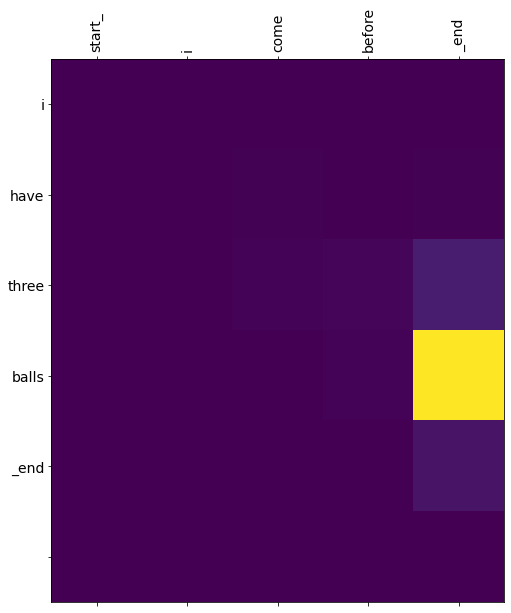

In [53]:
translate(u'i come before')

In [54]:
translate(u'food want')

KeyError: 'food'


******* Luong Attention  STARTS******
query (decoder hidden state): (batch_size, hidden size)  (1, 1024)
values (encoder all hidden state): (batch_size, max_len, hidden size)  (1, 8, 1024)
query_with_time_axis:(batch_size, 1, hidden size)  (1, 1, 1024)
values_transposed:(batch_size, hidden size, max_len)  (1, 1024, 8)
score: (batch_size, max_length, 1)  (1, 8, 1)
attention_weights: (batch_size, max_length, 1)  (1, 8, 1)
context_vector before reduce_sum: (batch_size, max_length, hidden_size)  (1, 8, 1024)
context_vector after reduce_sum: (batch_size, hidden_size)  (1, 1024)

******* Luong Attention ENDS******

******* Luong Attention  STARTS******
query (decoder hidden state): (batch_size, hidden size)  (1, 1024)
values (encoder all hidden state): (batch_size, max_len, hidden size)  (1, 8, 1024)
query_with_time_axis:(batch_size, 1, hidden size)  (1, 1, 1024)
values_transposed:(batch_size, hidden size, max_len)  (1, 1024, 8)
score: (batch_size, max_length, 1)  (1, 8, 1)
attention_weight

<ipython-input-50-71f02795d875>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
<ipython-input-50-71f02795d875>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


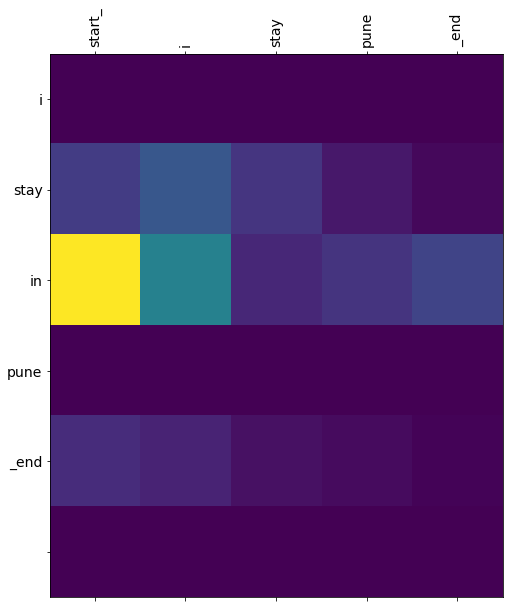

In [55]:
translate(u'i stay pune')

In [ ]:
translate(u'bank where')

In [ ]:
translate(u'i understand not')


******* Luong Attention  STARTS******
query (decoder hidden state): (batch_size, hidden size)  (1, 1024)
values (encoder all hidden state): (batch_size, max_len, hidden size)  (1, 8, 1024)
query_with_time_axis:(batch_size, 1, hidden size)  (1, 1, 1024)
values_transposed:(batch_size, hidden size, max_len)  (1, 1024, 8)
score: (batch_size, max_length, 1)  (1, 8, 1)
attention_weights: (batch_size, max_length, 1)  (1, 8, 1)
context_vector before reduce_sum: (batch_size, max_length, hidden_size)  (1, 8, 1024)
context_vector after reduce_sum: (batch_size, hidden_size)  (1, 1024)

******* Luong Attention ENDS******

******* Luong Attention  STARTS******
query (decoder hidden state): (batch_size, hidden size)  (1, 1024)
values (encoder all hidden state): (batch_size, max_len, hidden size)  (1, 8, 1024)
query_with_time_axis:(batch_size, 1, hidden size)  (1, 1, 1024)
values_transposed:(batch_size, hidden size, max_len)  (1, 1024, 8)
score: (batch_size, max_length, 1)  (1, 8, 1)
attention_weight

<ipython-input-50-71f02795d875>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
<ipython-input-50-71f02795d875>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


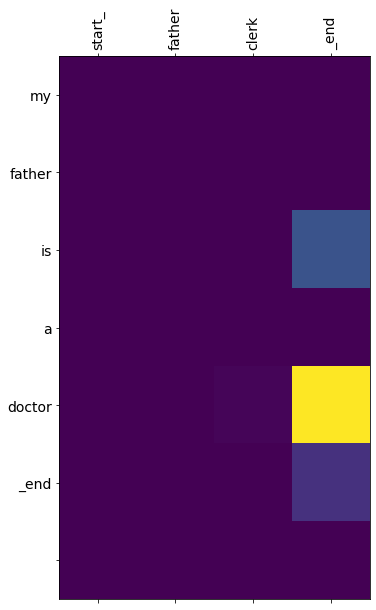

In [56]:
translate(u'father clerk')

In [ ]:
translate(u'you name what')

In [ ]:
translate(u'tomorrow together we go')

In [ ]:
translate(u'today date what')

In [ ]:
translate(u'pink color i like')

In [ ]:
translate(u'apple child eat')

In [ ]:
translate(u'this flower')

In [ ]:
translate(u'nine morning')

In [ ]:
translate(u'do job what')

In [ ]:
translate(u'school name what')

In [ ]:
translate(u'she say what')

In [ ]:
translate(u'pain head')

In [17]:
import nltk
hypothesis = ['It', 'is', 'a', 'cat', 'at', 'room']
reference = ['It', 'is', 'a', 'cat', 'inside', 'the', 'room']
#there may be several references
BLEUscore = nltk.translate.bleu_score.sentence_bleu([reference], hypothesis)
print(BLEUscore)

0.4548019047027907


In [18]:
hypothesis = ['I', 'stay', 'in', 'pune']
reference = ['I', 'stay', 'in', 'pune']
#there may be several references
BLEUscore = nltk.translate.bleu_score.sentence_bleu([reference], hypothesis)
print(BLEUscore)

1.0


In [19]:
hypothesis = ['father', 'clerk']
reference = ['my', 'father', 'is', 'doctor']
#there may be several references
BLEUscore = nltk.translate.bleu_score.sentence_bleu([reference], hypothesis)
print(BLEUscore)

5.635809992474887e-232


C:\Users\lenovo\anaconda3\lib\site-packages\nltk\translate\bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\lenovo\anaconda3\lib\site-packages\nltk\translate\bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\lenovo\anaconda3\lib\site-packages\nltk\translate\bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  war

In [20]:
import  nltk.translate.bleu_score as bleu
reference_translation=['The cat is on the mat.'.split(),
                       'There is a cat on the mat.'.split()
                      ]
candidate_translation_1='the the the mat on the the.'.split()
candidate_translation_2='The cat is on the mat.'.split()
print("BLEU Score: ",bleu.sentence_bleu(reference_translation, candidate_translation_1))
    

BLEU Score:  6.968148412761692e-155


In [21]:
import numpy as np
from nltk import ngrams
from collections import Counter

In [22]:
def count_ngram(unigram, ngram=1):
    """
    Return
    -----
    counter: dict, containing ngram as key, and count as value
    """
    return Counter(ngrams(unigram, ngram))

In [23]:
translation = 'It is a guide to action which ensures that the military always obeys the commands of the party.'.split()
list_of_references=[
    'It is a guide to action that ensures that the military will forever heed Party commands.',
    'It is the guiding principle which guarantees the military forces always being under the command of the Party.',
    'It is the practical guide for the army always to heed the directions of the party.'

]
res = count_ngram(translation)
print('unigram for translation {}'.format(res))
res = count_ngram(translation, 2)
print('Bigram for translation {}'.format(res))

unigram for translation Counter({('the',): 3, ('It',): 1, ('is',): 1, ('a',): 1, ('guide',): 1, ('to',): 1, ('action',): 1, ('which',): 1, ('ensures',): 1, ('that',): 1, ('military',): 1, ('always',): 1, ('obeys',): 1, ('commands',): 1, ('of',): 1, ('party.',): 1})
Bigram for translation Counter({('It', 'is'): 1, ('is', 'a'): 1, ('a', 'guide'): 1, ('guide', 'to'): 1, ('to', 'action'): 1, ('action', 'which'): 1, ('which', 'ensures'): 1, ('ensures', 'that'): 1, ('that', 'the'): 1, ('the', 'military'): 1, ('military', 'always'): 1, ('always', 'obeys'): 1, ('obeys', 'the'): 1, ('the', 'commands'): 1, ('commands', 'of'): 1, ('of', 'the'): 1, ('the', 'party.'): 1})


In [24]:
res = dict()
# retrieve translation unigram counts
ct_translation_u = count_ngram(translation, ngram=1)
ct_translation_u

Counter({('It',): 1,
         ('is',): 1,
         ('a',): 1,
         ('guide',): 1,
         ('to',): 1,
         ('action',): 1,
         ('which',): 1,
         ('ensures',): 1,
         ('that',): 1,
         ('the',): 3,
         ('military',): 1,
         ('always',): 1,
         ('obeys',): 1,
         ('commands',): 1,
         ('of',): 1,
         ('party.',): 1})

In [25]:
res = dict()
# retrieve translation unigram counts
ct_translation_b = count_ngram(translation, ngram=4)
ct_translation_b

Counter({('It', 'is', 'a', 'guide'): 1,
         ('is', 'a', 'guide', 'to'): 1,
         ('a', 'guide', 'to', 'action'): 1,
         ('guide', 'to', 'action', 'which'): 1,
         ('to', 'action', 'which', 'ensures'): 1,
         ('action', 'which', 'ensures', 'that'): 1,
         ('which', 'ensures', 'that', 'the'): 1,
         ('ensures', 'that', 'the', 'military'): 1,
         ('that', 'the', 'military', 'always'): 1,
         ('the', 'military', 'always', 'obeys'): 1,
         ('military', 'always', 'obeys', 'the'): 1,
         ('always', 'obeys', 'the', 'commands'): 1,
         ('obeys', 'the', 'commands', 'of'): 1,
         ('the', 'commands', 'of', 'the'): 1,
         ('commands', 'of', 'the', 'party.'): 1})

In [26]:
def count_clip_ngram(translation_u, list_of_reference_u, ngram=1):
    """
    Return
   clipped counts of the ngram for candidate and reference translation
    
    """
    res = dict()
    # retrieve hypothesis counts
    ct_translation_u = count_ngram(translation_u, ngram=ngram)
    
    # retrieve translation candidate counts
    for reference_u in list_of_reference_u:
        ct_reference_u = count_ngram(reference_u, ngram=ngram)
        for k in ct_reference_u:
            if k in res:
                res[k] = max(ct_reference_u[k], res[k])
            else:
                res[k] = ct_reference_u[k]
                

    return {
        k: min(ct_translation_u.get(k, 0), res.get(k, 0)) 
        for k in ct_translation_u
    }

In [27]:
res = count_clip_ngram(
    translation, 
    list(map(lambda ref: ref.split(), list_of_references))
)
print("Clipped counts for unigram between candidate and reference", res)

Clipped counts for unigram between candidate and reference {('It',): 1, ('is',): 1, ('a',): 1, ('guide',): 1, ('to',): 1, ('action',): 1, ('which',): 1, ('ensures',): 1, ('that',): 1, ('the',): 3, ('military',): 1, ('always',): 1, ('obeys',): 0, ('commands',): 0, ('of',): 1, ('party.',): 1}


In [28]:
def modified_precision(translation, list_of_references, ngram=1):
    """
    Return
    modified precision = clipped counts/ no. of unclipped candidate n-gram
    
    """
    ct_clip = count_clip_ngram(translation, list_of_references, ngram)
    ct = count_ngram(translation, ngram)
    
    return sum(ct_clip.values()) / float(max(sum(ct.values()), 1))

In [29]:
res_mp= modified_precision(translation, list_of_references)
print("Modofied precision", res_mp)

Modofied precision 0.05555555555555555


In [30]:
def closest_ref_length(translation_u, list_of_reference_u):
    """
    determine the closest reference length from translation length
    """
    len_trans = len(translation_u)
    closest_ref_idx = np.argmin([abs(len(x) - len_trans) for x in list_of_reference_u])
    return len(list_of_reference_u[closest_ref_idx])

In [31]:
ref_length = closest_ref_length(translation, list_of_references)
ref_length

82

In [33]:
def brevity_penalty(translation_u, list_of_reference_u):
    """
    """
    c = len(translation_u)
    r = closest_ref_length(translation_u, list_of_reference_u)
    
    if c > r:
        return 1
    else:
        return np.exp(1 - float(r)/c)

In [34]:
print("BP", brevity_penalty(translation, list_of_references))

BP 0.028565500784550377


In [35]:
def bleu_score(translation_u, list_of_reference_u, W=[0.25 for x in range(4)]):
    bp = brevity_penalty(translation_u, list_of_reference_u)
    modified_precisions = [
        modified_precision(translation_u, list_of_reference_u, ngram=ngram)
        for ngram, _ in enumerate(W,start=1)
    ]
    score = np.sum([
        wn * np.log(modified_precisions[i]) if modified_precisions[i] != 0 else 0 for i, wn in enumerate(W)
    ])
    
    return bp * np.exp(score)

In [36]:
print("BLEU", bleu_score(translation, list_of_references))

BLEU 0.013868315585598298
